# UCIHAR exploratory analysis

# Importações e Mount

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pré-processamento

In [54]:
# Caminho da pasta extraída
path = "/content/drive/MyDrive/Faculdade/SEXTO PERIODO/TOPICOS S. EM COMPUTAÇÃO/trabalho2/UCIHAR_dataset/UCI HAR Dataset/UCI HAR Dataset/"

# Carregar os nomes das features (atributos)
features = pd.read_csv(path + "features.txt", sep=r"\s+", header=None, names=["index", "feature"])
feature_names = features["feature"].values

# Make feature names unique
from collections import defaultdict
counts = defaultdict(int)
unique_feature_names = []
for name in feature_names:
    if name in counts:
        unique_feature_names.append(f"{name}_{counts[name]}")
    else:
        unique_feature_names.append(name)
    counts[name] += 1
feature_names = unique_feature_names

# Carregar os nomes das atividades
activities = pd.read_csv(path + "activity_labels.txt", sep=r"\s+", header=None, names=["id", "activity"])

# Carregar dados de treino
X_train = pd.read_csv(path + "train/X_train.txt", sep=r"\s+", header=None, names=feature_names)
y_train = pd.read_csv(path + "train/y_train.txt", sep=r"\s+", header=None, names=["Activity"])
subject_train = pd.read_csv(path + "train/subject_train.txt", sep=r"\s+", header=None, names=["Subject"])

# Carregar dados de teste
X_test = pd.read_csv(path + "test/X_test.txt", sep=r"\s+", header=None, names=feature_names)
y_test = pd.read_csv(path + "test/y_test.txt", sep=r"\s+", header=None, names=["Activity"])
subject_test = pd.read_csv(path + "test/subject_test.txt", sep=r"\s+", header=None, names=["Subject"])

# Juntar treino + teste
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
subjects = pd.concat([subject_train, subject_test], axis=0).reset_index(drop=True)

# Identifique número de amostras, atributos e classes.
print("Número de amostras:", len(X))
print("Número de atributos:", len(X.columns))
print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Número de classes:", len(y["Activity"].unique()))
print("Classes únicas:", y["Activity"].unique())

Número de amostras: 10299
Número de atributos: 561
Formato de X: (10299, 561)
Formato de y: (10299, 1)
Número de classes: 6
Classes únicas: [5 4 6 1 3 2]


In [55]:
# Substituir IDs pelos nomes das atividades
y["Activity"] = y["Activity"].map(dict(zip(activities.id, activities.activity)))

y["Activity"].value_counts()

,count
Activity,
LAYING,1944
STANDING,1906
SITTING,1777
WALKING,1722
WALKING_UPSTAIRS,1544
WALKING_DOWNSTAIRS,1406


### Normalização

In [41]:
# Instancia o scaler
scaler = StandardScaler()

# Aplica a normalização
X_scaled = scaler.fit_transform(X)

print("Formato após normalização:", X_scaled.shape)

# Cria um DataFrame para exibir a média e o desvio padrão
stats_df = pd.DataFrame({
    "Média (aproximada)": X_scaled.mean(axis=0),
    "Desvio Padrão": X_scaled.std(axis=0)
})

print("\nEstatísticas das features normalizadas:")
display(stats_df.head()) # Mostra os primeiros 5 atributos para resumo

Formato após normalização: (10299, 561)

Estatísticas das features normalizadas:


,Média (aproximada),Desvio Padrão
0,-2.387103e-16,1.0
1,3.578930e-18,1.0
2,-3.095990e-16,1.0
3,-1.724786e-16,1.0
4,-2.411250e-16,1.0


### Separação de X e y

In [57]:
print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)
print("Exemplo de rótulos:", y["Activity"].unique())

X_scaled shape: (10299, 561)
y shape: (10299, 1)
Exemplo de rótulos: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [6]:
data = pd.DataFrame(X_scaled, columns=feature_names)
data["Activity"] = y["Activity"].values

data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151,STANDING
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121,STANDING
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214,STANDING
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624,STANDING
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649,STANDING


# Redução de Dimensionalidade com PCA

### Aplicando PCA para 2 componentes

In [49]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(X_pca_2d.shape)
print(pca_2d.explained_variance_ratio_)

# Determine quantos componentes são necessários para explicar pelo menos 90%
# da variância.
explained_variance_cum = pca_2d.explained_variance_ratio_.cumsum()
n_comp_90 = int(np.argmax(explained_variance_cum >= 0.9) + 1)

(10299, 2)
[0.50738221 0.06239186]
Componentes necessários para ≥90%: 1


## Gráfico de dispersão 2D

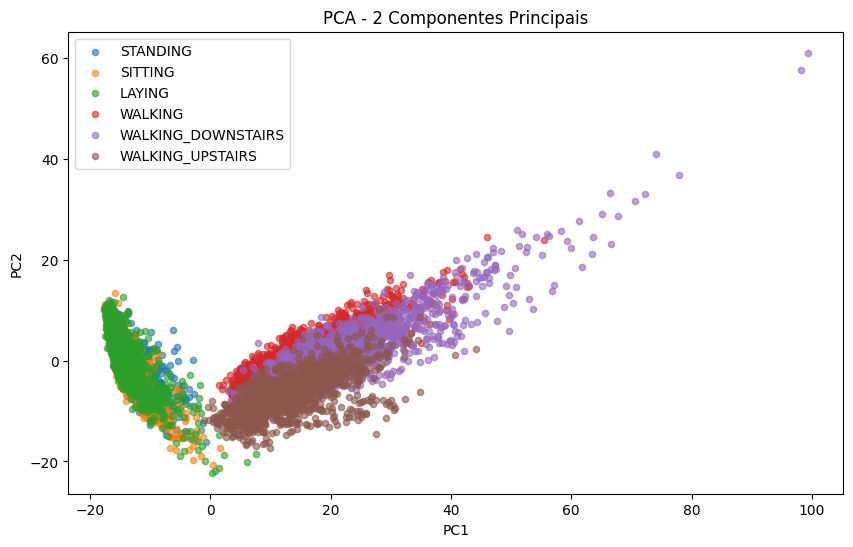

In [ ]:
plt.figure(figsize=(10, 6))
for activity in y["Activity"].unique():
    idx = y["Activity"] == activity
    plt.scatter(X_pca_2d[idx, 0], X_pca_2d[idx, 1], label=activity, alpha=0.6, s=20)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - 2 Componentes Principais")
plt.legend()
plt.show()

# Seleção de Características

## Recursive Feature Elimination (RFE)

In [12]:
# Modelo base
logreg = LogisticRegression(max_iter=1000, solver="liblinear")

# RFE (reduzindo de 561 até 1)
rfe = RFE(logreg, n_features_to_select=1, step=1, verbose=1)
rfe.fit(X_scaled, y["Activity"])

# Features ranqueadas
ranking = pd.DataFrame({
    "Feature": feature_names,
    "Ranking": rfe.ranking_
}).sort_values("Ranking")

# Salvar em CSV
ranking.to_csv("rfe_ranking.csv", index=False)

print("Ranking salvo em 'rfe_ranking.csv'")
print(ranking.head(15))  # mostra as 15 melhores


Fitting estimator with 561 features.
Fitting estimator with 560 features.
Fitting estimator with 559 features.
Fitting estimator with 558 features.
Fitting estimator with 557 features.
Fitting estimator with 556 features.
Fitting estimator with 555 features.
Fitting estimator with 554 features.
Fitting estimator with 553 features.
Fitting estimator with 552 features.
Fitting estimator with 551 features.
Fitting estimator with 550 features.
Fitting estimator with 549 features.
Fitting estimator with 548 features.
Fitting estimator with 547 features.
Fitting estimator with 546 features.
Fitting estimator with 545 features.
Fitting estimator with 544 features.
Fitting estimator with 543 features.
Fitting estimator with 542 features.
Fitting estimator with 541 features.
Fitting estimator with 540 features.
Fitting estimator with 539 features.
Fitting estimator with 538 features.
Fitting estimator with 537 features.
Fitting estimator with 536 features.
Fitting estimator with 535 features.
F

## Lasso (L1 Regularization)

In [13]:
# Logistic Regression com regularização L1 (Lasso)
lasso = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l1",
    solver="liblinear",
    max_iter=1000
)

lasso.fit(X_scaled, y["Activity"])

# Coeficientes médios
coef = np.mean(np.abs(lasso.coef_), axis=0)

# DataFrame com todas as features + pesos
lasso_ranking = pd.DataFrame({
    "Feature": feature_names,
    "Coeficiente": coef
}).sort_values("Coeficiente", ascending=False)

# Salvar em CSV
lasso_ranking.to_csv("lasso_ranking.csv", index=False)

print("Ranking salvo em 'lasso_ranking.csv'")

Ranking salvo em 'lasso_ranking.csv'
                         Feature  Coeficiente
182    tBodyGyroJerk-entropy()-X     4.072470
56        tGravityAcc-energy()-X     3.586967
57        tGravityAcc-energy()-Y     3.520928
40          tGravityAcc-mean()-X     3.275410
49           tGravityAcc-max()-X     2.234199
41          tGravityAcc-mean()-Y     1.943051
58        tGravityAcc-energy()-Z     1.936879
52           tGravityAcc-min()-X     1.773826
104     tBodyAccJerk-entropy()-Z     1.722421
559         angle(Y,gravityMean)     1.561152
558         angle(X,gravityMean)     1.448809
50           tGravityAcc-max()-Y     1.345479
193  tBodyGyroJerk-arCoeff()-Z,1     1.341643
102     tBodyAccJerk-entropy()-X     1.323296
246           tBodyGyroMag-iqr()     1.312355


In [50]:
lasso_ranking.head(15)

,Feature,Coeficiente
0,tBodyGyroJerk-entropy()-X,4.072470
1,tGravityAcc-energy()-X,3.586967
2,tGravityAcc-energy()-Y,3.520928
3,tGravityAcc-mean()-X,3.275410
4,tGravityAcc-max()-X,2.234199
5,tGravityAcc-mean()-Y,1.943051
6,tGravityAcc-energy()-Z,1.936879
7,tGravityAcc-min()-X,1.773826
8,tBodyAccJerk-entropy()-Z,1.722421
9,"angle(Y,gravityMean)",1.561152


In [36]:
selected_features_lasso = np.array(feature_names)[coef > 1e-5]
discarded_features_lasso = np.array(feature_names)[coef <= 1e-5]

print("Selecionados pelo Lasso:", len(selected_features_lasso))
print("Descartados pelo Lasso:", len(discarded_features_lasso))

Selecionados pelo Lasso: 513
Descartados pelo Lasso: 48


## RFE vs Lasso

In [52]:
# Carregar os resultados salvos
rfe_ranking = pd.read_csv("rfe_ranking.csv")
lasso_ranking = pd.read_csv("lasso_ranking.csv")

# Top 30 de cada método
top_rfe = rfe_ranking.sort_values("Ranking").head(30)["Feature"].tolist()
top_lasso = lasso_ranking.sort_values("Coeficiente", ascending=False).head(30)["Feature"].tolist()

# Comparação
common_features = set(top_rfe).intersection(set(top_lasso))

print("Em comum:", len(common_features))
common_features

Em comum: 15


{'angle(X,gravityMean)',
 'fBodyAccJerk-entropy()-X',
 'fBodyAccMag-energy()',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-entropy()-Y',
 'tBodyAccJerk-entropy()-X',
 'tBodyAccJerk-entropy()-Z',
 'tBodyGyroJerk-arCoeff()-Z,1',
 'tBodyGyroJerk-entropy()-X',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Y',
 'tGravityAcc-max()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-min()-Y'}

# Visualizações

## Ajustes de segurança / caminhos

In [18]:
OUT_DIR = "plots_uci_har"
os.makedirs(OUT_DIR, exist_ok=True)

## Helper: carregar X/y se não estiverem na sessão

In [19]:
# Tentar usar variáveis já carregadas no notebook; caso contrário, tente carregar arquivos CSVs.
try:
    X_scaled
    y
    feature_names
    print("Usando X_scaled, y, feature_names já definidos no ambiente.")
except NameError:
    # tenta carregar arquivos comuns (caso você já os tenha salvo)
    loaded = False
    if os.path.exists("X_scaled.npy") and os.path.exists("y.npy") and os.path.exists("feature_names.npy"):
        X_scaled = np.load("X_scaled.npy")
        y = pd.read_csv("y.csv") if os.path.exists("y.csv") else pd.DataFrame(np.load("y.npy"), columns=["Activity"])
        feature_names = np.load("feature_names.npy")
        loaded = True
        print("Carreguei X_scaled.npy, y (y.csv ou y.npy), feature_names.npy do disco.")
    else:
        # tentar carregar os arquivos UCI (se a pasta existir localmente)
        if os.path.exists("UCI HAR Dataset"):
            path = "UCI HAR Dataset/"
            features = pd.read_csv(path + "features.txt", sep=r"\s+", header=None, names=["index", "feature"])
            feature_names = features["feature"].values
            X_train = pd.read_csv(path + "train/X_train.txt", sep=r"\s+", header=None, names=feature_names)
            X_test = pd.read_csv(path + "test/X_test.txt", sep=r"\s+", header=None, names=feature_names)
            X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
            y_train = pd.read_csv(path + "train/y_train.txt", sep=r"\s+", header=None, names=["Activity"])
            y_test = pd.read_csv(path + "test/y_test.txt", sep=r"\s+", header=None, names=["Activity"])
            y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
            # normalizar (se scaler não existir)
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            loaded = True
            print("Carregado e normalizado o dataset UCI HAR disponível localmente.")
    if not loaded:
        raise RuntimeError(
            "Não encontrei X_scaled/y/feature_names no ambiente nem arquivos auxiliares. "
            "Salve X_scaled como 'X_scaled.npy', y como 'y.csv' ou 'y.npy' e feature_names como 'feature_names.npy', "
            "ou rode a preparação mostrada anteriormente para criar essas variáveis."
        )

# Garantir y como Series de rótulos (nomes das atividades)
if isinstance(y, pd.DataFrame):
    if "Activity" in y.columns:
        y_series = y["Activity"]
    else:
        # se y foi salvo apenas como valores numéricos
        y_series = y.iloc[:, 0]
else:
    y_series = pd.Series(y)

Usando X_scaled, y, feature_names já definidos no ambiente.


## PCA 2D scatter (PC1 x PC2)

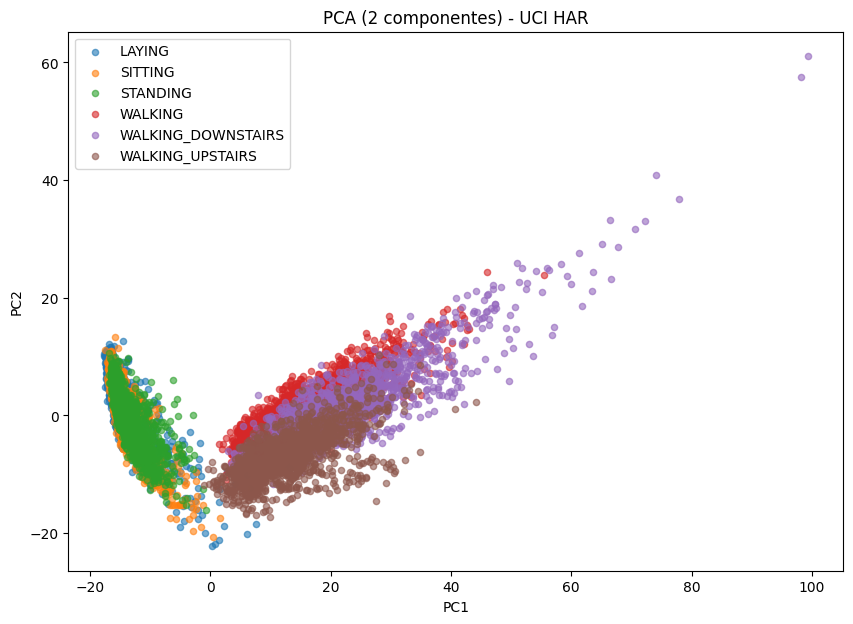

Salvo: plots_uci_har/pca_2d_scatter.png


In [44]:

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
unique_acts = np.unique(y_series)
for act in unique_acts:
    mask = (y_series == act).values
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], alpha=0.6, s=20, label=str(act))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2 componentes) - UCI HAR")
plt.legend()
pca2d_path = os.path.join(OUT_DIR, "pca_2d_scatter.png")
plt.savefig(pca2d_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Salvo:", pca2d_path)

## Scree plot - variância explicada acumulada

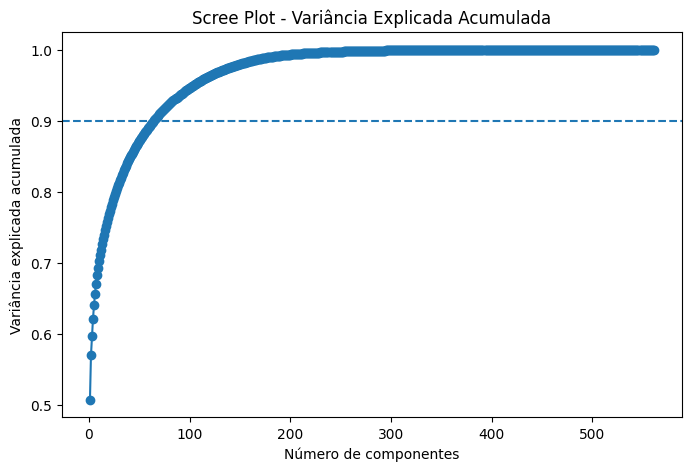

Salvo: plots_uci_har/scree_plot.png 
Componentes necessários para ≥90%: 65


In [45]:
pca_full = PCA()
pca_full.fit(X_scaled)
explained_variance_cum = pca_full.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_cum) + 1), explained_variance_cum, marker="o")
plt.axhline(y=0.9, linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Variância explicada acumulada")
plt.title("Scree Plot - Variância Explicada Acumulada")
scree_path = os.path.join(OUT_DIR, "scree_plot.png")
plt.savefig(scree_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
# encontrar n_components para >= 90%
n_comp_90 = int(np.argmax(explained_variance_cum >= 0.9) + 1)
print(f"Salvo: {scree_path} ")
print(f"Componentes necessários para ≥90%: {n_comp_90}")

## Performance variando número de atributos no RFE

# se existir, mas talvez sem os scores; tentamos carregar resumo


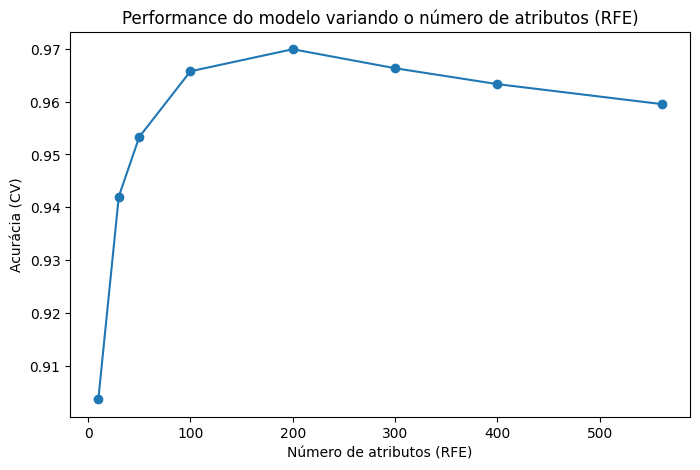

Salvo: plots_uci_har/rfe_performance.png
Melhor número de atributos (RFE): 200 (acurácia: 0.969900649292474)


In [46]:
# Se não existir rfe_ranking.csv, vamos rodar avaliações com RFE de forma incremental (passo maior para desempenho).
if not os.path.exists("rfe_ranking.csv"):
    print("rfe_ranking.csv não encontrado — calculando performance RFE (pode demorar).")
    base_model = LogisticRegression(max_iter=1000, solver="liblinear")
    # testar conjuntos de tamanhos (ajuste os valores conforme seu tempo)
    feature_counts = [10, 30, 50, 100, 200, 300, 400, X_scaled.shape[1]]
    rfe_scores = []
    for n in feature_counts:
        print("Avaliando RFE com n_features =", n)
        rfe = RFE(base_model, n_features_to_select=n, step=max(1, n//10))
        rfe.fit(X_scaled, y_series)
        # cross-val na submatriz selecionada
        try:
            scores = cross_val_score(base_model, X_scaled[:, rfe.support_], y_series, cv=5, n_jobs=-1)
            mean_score = scores.mean()
        except Exception as e:
            print("Cross-val falhou:", e)
            mean_score = np.nan
        rfe_scores.append(mean_score)
    # salvar um CSV resumido
    rfe_perf_df = pd.DataFrame({"n_features": feature_counts, "cv_accuracy": rfe_scores})
    rfe_perf_df.to_csv("rfe_performance_summary.csv", index=False)
else:
    # se existir, mas talvez sem os scores; tentamos carregar resumo
    if os.path.exists("rfe_performance_summary.csv"):
        print("# se existir, mas talvez sem os scores; tentamos carregar resumo")
        rfe_perf_df = pd.read_csv("rfe_performance_summary.csv")
        feature_counts = rfe_perf_df["n_features"].tolist()
        rfe_scores = rfe_perf_df["cv_accuracy"].tolist()
    else:
        # carregue top ranks e avalie (carregará ranking completo e usará os melhores k)
        print("carregue top ranks e avalie (carregará ranking completo e usará os melhores k)")
        rfe_df = pd.read_csv("rfe_ranking.csv")
        rfe_df = rfe_df.sort_values("Ranking")
        feature_counts = [10, 30, 50, 100, 200, 300, 400, X_scaled.shape[1]]
        base_model = LogisticRegression(max_iter=1000, solver="liblinear", verbose=1)
        rfe_scores = []
        for n in feature_counts:
            selected = rfe_df.head(n)["Feature"].values
            # mapear colunas do X_scaled
            cols_idx = [i for i, f in enumerate(feature_names) if f in selected]
            try:
                scores = cross_val_score(base_model, X_scaled[:, cols_idx], y_series, n_jobs=-1)
                rfe_scores.append(scores.mean())
            except Exception as e:
                print("Cross-val falhou:", e)
                rfe_scores.append(np.nan)
        pd.DataFrame({"n_features": feature_counts, "cv_accuracy": rfe_scores}).to_csv("rfe_performance_summary.csv", index=False)

# plot RFE performance
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, rfe_scores, marker="o")
plt.xlabel("Número de atributos (RFE)")
plt.ylabel("Acurácia (CV)")
plt.title("Performance do modelo variando o número de atributos (RFE)")
rfe_perf_path = os.path.join(OUT_DIR, "rfe_performance.png")
plt.savefig(rfe_perf_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Salvo:", rfe_perf_path)


melhor_numero_atributos = feature_counts[np.argmax(rfe_scores)]
melhor_acuracia = rfe_scores[np.argmax(rfe_scores)]
print(f"Melhor número de atributos (RFE): {melhor_numero_atributos} (acurácia: {melhor_acuracia})")


## Visualização dos coeficientes do Lasso

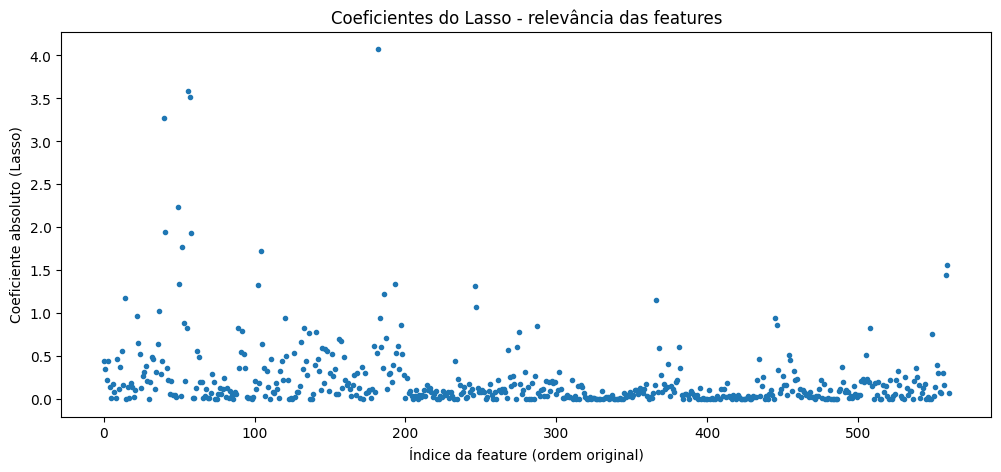

Salvo: plots_uci_har/lasso_coefficients.png

Arquivos gerados no diretório: plots_uci_har
 - lasso_coefficients.png
 - pca_2d_scatter.png
 - rfe_performance.png
 - scree_plot.png

Arquivos CSV gerados/consultados:
 - rfe_ranking.csv
 - lasso_ranking.csv
 - rfe_performance_summary.csv


In [47]:

# Se não existir lasso_ranking.csv, rodamos LogisticRegressionCV (L1) — isso pode demorar.
if os.path.exists("lasso_ranking.csv"):
    lasso_df = pd.read_csv("lasso_ranking.csv")
else:
    print("lasso_ranking.csv não encontrado — ajustando LogisticRegressionCV L1 (pode demorar).")
    lasso = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear", max_iter=1000)
    lasso.fit(X_scaled, y_series)
    coef = np.mean(np.abs(lasso.coef_), axis=0)
    lasso_df = pd.DataFrame({"Feature": feature_names, "Coeficiente": coef})
    lasso_df = lasso_df.sort_values("Coeficiente", ascending=False)
    lasso_df.to_csv("lasso_ranking.csv", index=False)

# plot coeficientes do lasso
plt.figure(figsize=(12, 5))
# plotando coeficientes (mantendo a ordem do feature index original)
# mapear coef para índices (se lasso_df for ordenado, vamos reindexar)
coef_map = dict(zip(lasso_df["Feature"], lasso_df["Coeficiente"]))
coefs_in_order = [coef_map.get(f, 0.0) for f in feature_names]

plt.plot(np.arange(len(coefs_in_order)), coefs_in_order, marker=".", linestyle="")
plt.xlabel("Índice da feature (ordem original)")
plt.ylabel("Coeficiente absoluto (Lasso)")
plt.title("Coeficientes do Lasso - relevância das features")
lasso_plot_path = os.path.join(OUT_DIR, "lasso_coefficients.png")
plt.savefig(lasso_plot_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Salvo:", lasso_plot_path)

# ---------- Final: resumo dos arquivos gerados ----------
print("\nArquivos gerados no diretório:", OUT_DIR)
for fname in sorted(os.listdir(OUT_DIR)):
    print(" -", fname)

print("\nArquivos CSV gerados/consultados:")
for f in ["rfe_ranking.csv", "lasso_ranking.csv", "rfe_performance_summary.csv"]:
    if os.path.exists(f):
        print(" -", f)


# Análise de Padrões e Tendências

A redução de dimensionalidade via PCA mostrou que as atividades apresentam certa separação no espaço bidimensional, especialmente entre movimentos mais distintos, como “WALKING” e “LAYING”. No entanto, classes semelhantes, como “SITTING” e “STANDING”, apresentaram sobreposição, evidenciando que o PCA facilita a visualização mas perde parte da interpretabilidade dos atributos originais, já que os componentes principais são combinações lineares e não atributos diretamente observáveis.

Na seleção de características, observou-se que RFE e Lasso não escolheram exatamente o mesmo conjunto de atributos, mas houve interseções relevantes, indicando concordância parcial entre os métodos. O RFE baseia-se na performance iterativa do modelo, enquanto o Lasso impõe uma penalização direta sobre os coeficientes, eliminando variáveis com pouca influência.

Como benefícios, o PCA reduz a dimensionalidade e facilita a visualização global dos dados; o RFE é útil para ranquear atributos pela sua importância prática na classificação; e o Lasso fornece um critério objetivo de seleção automática, reduzindo atributos redundantes. Por outro lado, o PCA perde interpretabilidade; o RFE pode ser computacionalmente custoso em bases grandes como a HAR; e o Lasso pode descartar variáveis relevantes em cenários de alta correlação entre atributos. No contexto da base HAR, a combinação dessas técnicas se complementa, permitindo tanto uma análise visual clara quanto uma seleção mais criteriosa de atributos relevantes para a identificação das atividades humanas.